# **Tópicos em Sistemas Inteligentes**


## **Trabalho Prático 1 - Computação Financeira**  
  
  
#### Desenvolver um conjunto de experimentos utilizando aprendizado de máquinas para criar estratégias de investimento automatizado. Para isso, deverá desenvolver, através da estrutura de simulação simplificada, a criação de uma base de dados para induzir modelos de Aprendizado de Máquinas Supervisionado (**AMS**) como forma de tomada de decisão. O framework sugerido deverá ser composto das seguintes etapas:

#### • **Etapa 1** - Criação da base de dados para Aprendizado Supervisionado: desenvolvimento de algoritmo para criação de base de dados para ser utilizada na indução de modelos de aprendizado de máquinas supervisionado  

#### • **Etapa 2** - Criação e Análise dos modelos de Aprendizado de Máquinas Supervisionado: criação e validação dos modelos de aprendizado de máquinas supervisionado. Nesta etapa, você deverá salvar as saídas dos modelos para serem utilizados na etapa seguinte  

#### • **Etapa 3** - Criação de estratégias de investimento utilizando AM e análise de retorno: desenvolvimento de estratégia de investimento automatizado que utilize a saída dos modelos de aprendizado de máquinas como entrada para tomada de decisões. Nesta etapa, você deverá realizar a análise do retorno das estratégias dos modelos.  


#### Para o desenvolvimento dos experimentos, você deverá utilizar dados diários de alguma ação pertencente ao Índice Bovespa

## **Instalação da TA-Lib para criação dos *features***


In [1]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=3dfac37a7fb08175463e61dba562c715259aa810dce29ed814edf241a132d10c
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


### **Importação da Base de Dados em seu Formato *CSV***

In [2]:
import pandas as pd

# BRA - Eletrobras (ELET3)
df = pd.read_csv("./sample_data/eletrobras.csv")


## **Cálculo dos Indicadores de Análise Técnica**

#### Muitos dos indicadores descritos nesse trabalho foram encontrados [aqui](https://www.investopedia.com)

## **Legenda**:  
#### . **MM**: Média Móvel  
##### A **MM** pode ser calculada usando.  

$$\text{MM} = \dfrac{1}{N}\sum_{i=1}^{N}P_i = \overline{P}$$  

##### Que nada mais é do que o Preço médio em uma janela deslizante de tempo. (O fato da janela ser delizante é o que deriva a característica de ser móvel). O preço $P$ é sempre referente ao preço de fechamento.

#### . **MMC**: MM Curta  
#### . **MMM**: MM Média  
#### . **MML**: MM longa  
#### . **MMEXP**: MM Exponencial  
##### A Média Móvel Exponencial pode ser calculada por.  

$$\text{MMEXP}_t = αP_t + (1-α)\text{MMEXP}_{t-1}\text{, }α=\dfrac{2}{N + 1}$$

#### . **BB**: Bandas de *Bollinger* (Dada uma **MM**, as bandas de *Bollinger*, Inferior e Superior, consiste no incremento e decremento do Desvio Padrão da **MM** referencia dentro da própria **MM** escolhida)   

#### . **ROC** (Price Rate of Change): Diz respeito ao momento de mercado. Dado por.

$$\text{ROC} = \Big(\dfrac{P_t - P_{t - N}}{P_{t - N}}\Big) \text{ x } 100$$  

##### $N$ é o período desejado (Para esta simulação, $N=14$).

#### . **RSI** (Relative Strength Index): Outro indicador de **momento de mercado**. Mede a velocidade e a magnitude das mudanças recentes no preço de um título para avaliar as condições sobrevalorizadas ou subvalorizadas no preço desse título. Dado por.

$$\text{RSI} = 100 - \Big(\dfrac{100}{1 + \frac{\overline{G}}{\overline{L}}}\Big)$$  

##### $N$ é o período desejado (Para esta simulação, $N=14$), $\overline{G}$ é a média dos ganhos e $\overline{L}$ é a média das perdas (Em módulo).

#### . **K Curve** $\&$ **D Curve**: Osciladores Estocásticos que "seguem" a velocidade ou o momento dos preços. Indicadores criados por George Lane. Tipicamente utilizados em um período de $14$ dias. Podem ser encontrados usando.

$$\%K = 100 \text{ x } \Big(\dfrac{P_t - \text{min}(P_{[t, t - N]})}{\text{max}(P_{[t, t - N]}) - \text{min}(P_{[t, t - N]})}\Big)$$

#### e

$$\%D = \text{MM}(\%K_{[t, t - P]})$$  

##### $P_{[t, t - N]}$ representa os preços dentro dos ultimos $N$ dias ($N=14$, ou seja o maior e o menor preço dentro dos ultimos $14$ dias partindo do tempo $t$) e a $\%D$ é a média móvel das curvas $\%K$ em um período de $P$ dias.

#### . **CCI** (Commodity Channel Index): é um oscilador baseado em momento usado para ajudar a determinar quando um veículo de investimento está atingindo uma condição de sobrecompra ou sobrevenda. Dado por.

$$\text{CCI} = \dfrac{\text{Typical Price} - \text{MM}}{0.015σ}$$  

##### Tudo dentro de um período $P$ (Tipicamente $P=20$ dias). Cada um dos elementos presentes acima podem ser encontrados.

$$\text{Typical Price} = \sum_{i=1}^{P}\Big(\dfrac{1}{3}(\text{High} + \text{Low} + \text{Close})\Big)$$    
$$\text{MM (nesse contexto)} = \dfrac{1}{P}\sum_{i=1}^{P}\text{Typical Price}$$  
$$\sigma \text{(nesse contexto)} = \dfrac{1}{P}\sum_{i=1}^{P}|\text{Typical Price} - \text{MM}|$$


#### . **ATR** (Average True Range): Mede a volatilidade do mercado decompondo toda a faixa de preços de um ativo para aquele período. Introduzido por J. Welles Wilder Jr. em seu livro *New Concepts in Technical Trading Systems*. Antes devemos calcular o *True Range* (**TR**) que é dado por.

$$\text{TR}_i = \text{High}_i - \text{Low}_i$$  

#### Então, o **ATR** é dado por.

$$\text{ATR} = \dfrac{1}{N}\sum_{i=1}^{N}\text{TR}_i$$

#### . **ADI** ou **A/D** (Accumulation distribution indicator): É um indicador cumulativo que utiliza volume e preço para avaliar se um estoque está sendo acumulado ou distribuído. A medida A/D busca identificar divergências entre o preço das ações e o fluxo de volume. Isso fornece informações sobre o quão forte é uma tendência. Se o preço estiver a subir, mas o indicador estiver a cair, então isso sugere que o volume de compra ou acumulação pode não ser suficiente para apoiar o aumento dos preços e que poderá ocorrer uma descida dos preços. Dado por.

$$\text{MFM} = \dfrac{(\text{Close} - \text{Low}) + (\text{High} - \text{Close})}{\text{High} - \text{Low}}$$  

#### **MFM** é Multiplicador de fluxo de dinheiro. Podemos ainda encontrar **MFV** (Volume de Fluxo de Dinheiro) multiplicando **MFM** pelo volume atual, isto é $\text{MFV} = \text{MFM x Volume}$, e, com tudo isso, podemos encontrar A/D.

$$\text{A/D}_t = \text{A/D}_{t - 1} + \text{MFV}_t$$


#### . **RVI** (Relative Vigor Index): Indicador de momento de mercado. Ele mede a força de uma tendência comparando o preço de fechamento de um título com sua faixa de negociação, ao mesmo tempo que suaviza os resultados usando uma média móvel simples (SMA).  
#### A utilidade do **RVI** baseia-se na tendência observada de os preços fecharem mais alto do que abrem durante as tendências de alta e fecharem mais baixo do que abrem nas tendências de baixa. Dado por

$$A = \dfrac{a + d + 2(b + c)}{6}$$  
$$B = \dfrac{e + h + 2(f + g)}{6}$$  
$$\text{RVI} = \dfrac{\text{SMA(A)}_{[t,t-N]}}{\text{SMA(B)}_{[t,t-N]}}$$  
$$\text{Signal Line} = \dfrac{\text{RVI} + k + 2(i + j)}{6}$$

#### Onde $a,b,c$ e $d$ nada mais é do que a diferença entre Close e Open dentro de uma janela de $4$ dias:

$$a = ΔP_t \text{, isto é Close - Open no dia } t$$
$$b = \Delta P_{t-1} \text{, } 1 \text{ dia antes de } a$$
$$c = \Delta P_{t - 2}$$
$$d = \Delta P_{t - 3}$$  

#### $e,f,g$ e $h$ nada mais é do que a diferença entre High e Low (Chamemos essa diferença de $\Delta L$) dentro de uma janela de $4$ dias:

$$e = ΔL_t$$
$$f = \Delta L_{t - 1}$$
$$g = \Delta L_{t - 2}$$
$$h = \Delta L_{t - 3}$$  

#### $i,j$ e $k$ nada mais é do que os valores de **RVI** dentro de uma janela de $3$ dias:

$$i=\text{RVI}_{t - 1}$$
$$j=\text{RVI}_{t - 2}$$
$$k=\text{RVI}_{t - 3}$$

#### E, finalmente, $N$ é o período da análise.

#### . **Disp** (Disparity Index): Indicador técnico que mede a posição relativa do preço de fechamento mais recente de um ativo em relação a uma média móvel selecionada e informa o valor como uma porcentagem. Semelhante à Taxa de Mudança (**ROC**) e outros indicadores semelhantes, o **índice de disparidade é melhor usado em conjunto com outras ferramentas!** Podemos encontrá-lo por.

$$\text{Disp}_N = \dfrac{P_t - \text{MM}_N}{\text{MM}_N}\text{ x } 100$$

In [85]:
import ta
import numpy as np

# Moving Average
df['MMC7']  = ta.trend.sma_indicator(df['Close'], window=7)
df['MMM20'] = ta.trend.sma_indicator(df['Close'], window=20)
df['MML50'] = ta.trend.sma_indicator(df['Close'], window=50)

df['MMC10']  = ta.trend.sma_indicator(df['Close'], window=10)
df['MMM30'] = ta.trend.sma_indicator(df['Close'], window=30)
df['MML100'] = ta.trend.sma_indicator(df['Close'], window=100)


# Stochastincs Indicators
df['KCurve'] = ta.momentum.stoch(df['High'], df['Low'], df['Close'], window=14, smooth_window=3)
df['DCurve'] = ta.momentum.stoch_signal(df['High'], df['Low'], df['Close'], window=14, smooth_window=3)

# Exponential Moving Average
df['MMEXP20'] = ta.trend.ema_indicator(df['Close'], window=20)

# Calculate Bollinger Bands with a window of 20 days

df['BBUpper'] = df['MMM20'] + (2.0 * ta.volatility.bollinger_hband(df['Close'], window=20, window_dev=0))
df['BBLower'] = df['MMM20'] - (2.0 * ta.volatility.bollinger_lband(df['Close'], window=20, window_dev=0))

# Others TAI
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
df['CCI'] = ta.trend.cci(df['High'], df['Low'], df['Close'], window=20, constant=0.015)
df['ROC'] = ta.momentum.ROCIndicator(df['Close'], window=14).roc()
df['ATR'] = ta.volatility.AverageTrueRange(df['High'], df['Low'], df['Close'], window=14).average_true_range()
df['ADI'] = ta.volume.AccDistIndexIndicator(df['High'], df['Low'], df['Close'], df['Volume']).acc_dist_index()

# Relative Vigor Index
numerator = df['Close'].diff()
denominator = df['Open'].diff()
df['RVI'] = numerator/ denominator

# Disparity Index
df['Disp7']  = df['Close'] / df['Close'].rolling(window=7).mean()
df['Disp10']  = df['Close'] / df['Close'].rolling(window=10).mean()
df['Disp20'] = df['Close'] / df['Close'].rolling(window=20).mean()
df['Disp30'] = df['Close'] / df['Close'].rolling(window=30).mean()
df['Disp50'] = df['Close'] / df['Close'].rolling(window=50).mean()
df['Disp100'] = df['Close'] / df['Close'].rolling(window=100).mean()

# Outputs - Label for the models
# Calculate the regressor output (GPT CODE!)
df['Return'] = df['Close'].shift(-1) - df['Close']

# Calculate the classifier output (GPT CODE!)
df['Action'] = (df['Return'] > 0).astype(int)

# LAG Features (return of the previous day)
df['Return_prev'] = (df['Return']).shift(1)
df['Return_log'] = np.log(df['Close']/ df['Close'].shift(1))


df.fillna(0, inplace=True)
df.replace([np.inf, -np.inf], 0, inplace=True)

#df.head(30)

### **Separação da Base em Treino-Teste (70%-30%)**

In [86]:
len_df = len(df)

train_length = round(0.7 * len_df)
test_length =  round(0.3 * len_df)

train_dataset = df[:train_length]
test_dataset =  df[train_length:]

### **Seleção das *Features* usados para indução dos modelos**

In [121]:
features = [
  #'Open',
  #'Close',
  'MMC7',
  'MMM20',
  'MML50',
  #'MMC10',
  #'MMM30',
  #'MML100',
  'KCurve',
  'DCurve',
  'MMEXP20',
  #'BBUpper',
  #'BBLower',
  'RSI',
  'CCI',
  'ROC',
  'ATR',
  #'ADI',
  'Disp7',
  'Disp10',
  'Disp20',
  #'Disp30',
  #'Disp50',
  #'Disp100',
  #'RVI',
  #'Return_prev',
  'Return_log'
]

# Label to the Classifiers
target_cls = 'Action' # cls = classification

# Label to the Regressor
target_reg = 'Return' # reg = regression

# Train features
X_train = train_dataset[features]

# Training labels
y_train_clfs = train_dataset[target_cls]
y_train_regs = train_dataset[target_reg]

# Test features
X_test = test_dataset[features]

# Test labels
y_test_clfs = test_dataset[target_cls]
y_test_regs = test_dataset[target_reg]

### **Pré-Processamento da Base de Dados**

In [122]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Remobing the first 100 days to avoid blank features
X_train = X_train.iloc[99: ]
y_train_clfs = y_train_clfs.iloc[99: ]
y_train_regs = y_train_regs.iloc[99: ]

# Create a different Dataset Standardized
# std_scaler = StandardScaler()
# std_X_train = std_scaler.fit_transform(X_train)
# std_y_train = std_scaler.fit_transform(y_train)

mm_scaler = MinMaxScaler(feature_range=(-1, 1))
mm_X_train = mm_scaler.fit_transform(X_train)
mm_X_test = mm_scaler.fit_transform(X_test)

In [99]:
X_train.head(100)

,MMC7,MMM20,MML50,KCurve,DCurve,MMEXP20,BBUpper,BBLower,RSI,CCI,ROC,ATR,Disp7,Disp20,Disp50,Return_log
99,5.850000,5.2355,5.7028,97.619048,95.934366,5.508465,15.7065,-5.2355,68.478997,150.240305,27.628866,0.295705,1.058120,1.182313,1.085432,0.017930
100,5.950000,5.2610,5.6862,79.761905,90.415328,5.544801,15.7830,-5.2610,58.881836,105.531895,22.453222,0.298155,0.989916,1.119559,1.035841,-0.049679
101,5.960000,5.2840,5.6632,59.523810,78.968254,5.545296,15.8520,-5.2840,50.281152,47.196823,15.384615,0.309001,0.931208,1.050341,0.980011,-0.059458
102,5.930000,5.3195,5.6480,67.857143,69.047619,5.559078,15.9585,-5.3195,53.305627,45.782505,21.581197,0.312644,0.959528,1.069649,1.007436,0.024912
103,5.867143,5.3545,5.6338,59.523810,62.301587,5.558213,16.0635,-5.3545,50.028232,35.012652,20.652174,0.308884,0.945946,1.036511,0.985125,-0.024912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,6.545714,6.2845,5.5418,96.969697,74.523127,6.250588,18.8535,-6.2845,69.142287,125.187406,9.298532,0.206676,1.023570,1.066115,1.208993,0.052079
195,6.580000,6.3170,5.5856,84.507042,76.885689,6.289580,18.9510,-6.3170,67.393546,132.387707,7.766990,0.202628,1.012158,1.054298,1.192352,-0.005988
196,6.630000,6.3680,5.6334,90.721649,90.732796,6.352477,19.1040,-6.3680,72.770581,169.039291,13.376835,0.217440,1.048265,1.091394,1.233713,0.042622
197,6.705714,6.4150,5.6872,86.725664,87.318118,6.422717,19.2450,-6.4150,74.920731,188.258765,15.472313,0.232623,1.057307,1.105222,1.246659,0.019944


## **Definição dos Objetivo - Cálculo do *BaseLine***

#### O *Baseline* serve como referencia para a *performance* dos modelos. O objetivo dos modelos é no mínimo ser MELHOR do que o *baseline*.

#### Para esse trabalho, o *Baseline* sera simplesmente a **Distrubuição da Classes Majoritária** presente na base de dados, ou seja, um modelo que "chuta" apenas um único valor (0 ou 1) para os **Classificadores**.

#### Para os **Regressores**, o *Baseline* será a Distância (**MAE** && **RMSE**) entre o retorno do dia anterior para o retorno do dia atual, ou seja, um modelo que chuta que o preço do mercado será constante entre os dias.

In [168]:
# Classifier Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score

# Regressors Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

# Classifiers baseline
counts = test_dataset[target_cls].value_counts(normalize=True)

# The number of 0s is greater than the number of 1s?
if counts[0] > counts[1]:
  cls_baseline = (test_length) * [0]
else:
  cls_baseline = (test_length) * [1]

baseline_accuracy = accuracy_score(y_test_clfs, cls_baseline)
baseline_precision = precision_score(y_test_clfs, cls_baseline)
baseline_recall = recall_score(y_test_clfs, cls_baseline)

print("Baseline for Classifiers")
print(f"\t[+] ACCURACY:\t{baseline_accuracy}")
print(f"\t[+] PRECISION:\t{baseline_precision}")
print(f"\t[+] RECALL:\t{baseline_recall}")


# Regressors baseline
reg_baseline = np.array(test_dataset['Return_prev'])
baseline_mae = mean_absolute_error(reg_baseline, test_dataset[target_reg])
baseline_rmse = np.sqrt(mean_squared_error(reg_baseline, test_dataset[target_reg]))

print(f'Regression Baseline:\n\t[+] MAE:\t{baseline_mae}')
print(f'\t[+] RMSE:\t{baseline_rmse}')

Baseline for Classifiers
	[+] ACCURACY:	0.5090470446320868
	[+] PRECISION:	0.5090470446320868
	[+] RECALL:	1.0
Regression Baseline:
	[+] MAE:	0.9388540410132687
	[+] RMSE:	1.212851418985683


#### Olhando para as métricas do *BaseLine* podemos perceber, no ato, que a classe majoritária é a classe $1$ devido ao seu *recall*. Lembrando que.  

$$\text{recall} = \dfrac{\text{TP}}{\text{TP} + \text{FN}}$$  

#### Como a saída é sempre $1$, então **não há ocorrência de FN** (Falsos Negativos) **na matriz de confusão**.

## **Treinamento e Teste dos Modelos (Base de Dados NÃO normalizada)**

#### As métricas que estão em **VERMELHO** são as que foram **INFERIORES** ao *Baseline*. As **VERDES** são as **SUPERIORES**, ou seja as que atingiram a "Meta". As em **AZUIS** são que performaram **EXATAMENTE IGUAL** ao *Baseline*.

In [124]:
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
import xgboost as xgb

from sklearn.pipeline import Pipeline

# If x < y, print red, if equals print blue, else print green
def compare_numbers(x: float, y: float, growing=True) -> str:
  if x < y:
    if growing:
      return f'\033[0;31m{x}\033[0m'
    else:
      return f'\033[0;32m{x}\033[0m'
  elif x == y:
    return f'\033[0;34m{x}\033[0m'
  else:
    if growing:
      return f'\033[0;32m{x}\033[0m'
    else:
      return f'\033[0;31m{x}\033[0m'

# Define classifier models
classifier_models = [
    RandomForestClassifier(n_estimators=90, random_state=33),
    MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=33),
    SVC(probability=True),
    KNeighborsClassifier(n_neighbors=5),
    xgb.XGBClassifier(objective='reg:linear', colsample_bytree=0.3, learning_rate=0.1,
                      max_depth=5, alpha=10, n_estimators=90, random_state=33)
]

# Define regressors models
regressor_models = [
    RandomForestRegressor(n_estimators=90, random_state=33),
    MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=33),
    SVR(),
    KNeighborsRegressor(n_neighbors=5),
    xgb.XGBRegressor(objective='reg:linear', colsample_bytree=0.3, learning_rate=0.1,
                      max_depth=5, alpha=10, n_estimators=90, random_state=33)
]

guesstures = {}

# Train and evaluate each classifier model
for model in classifier_models:
    model_name = type(model).__name__  # Get the name of the model class
    print(f"Training \033[1;97m{model_name}\033[0m")

    # Training
    model.fit(X_train, y_train_clfs)

    # Test
    y_pred_cls = model.predict(X_test)

    # Adding the model for future simulation
    guesstures[model_name] = y_pred_cls

    accuracy = accuracy_score(y_test_clfs, y_pred_cls)
    precision = precision_score(y_test_clfs, y_pred_cls)
    auc = roc_auc_score(y_test_clfs, model.predict_proba(X_test)[:, 1])
    recall = recall_score(y_test_clfs, y_pred_cls)

    print(f"\t[+] {model_name} ACCURACY: \t{compare_numbers(accuracy, baseline_accuracy)}")
    print(f"\t[+] {model_name} PRECISION:\t{compare_numbers(accuracy, baseline_precision)}")
    print(f"\t[+] {model_name} AUC:      \t{auc}")
    print(f"\t[+] {model_name} RECALL:   \t{compare_numbers(accuracy, baseline_recall)}")

    print("=" * 80)

# Train and evaluate each regressor model
for model in regressor_models:
    model_name = type(model).__name__  # Get the name of the model class
    print(f"Training \033[1;97m{model_name}\033[0m")

    # Training
    model.fit(X_train, y_train_regs)

    # Test the model
    y_pred_reg = model.predict(X_test)

    # Adding the model for future simulation
    guesstures[model_name] = y_pred_cls

    mae = mean_absolute_error(y_test_regs, y_pred_reg)
    rmse = np.sqrt(mean_squared_error(y_test_regs, y_pred_reg))

    print(f"\t[+] {model_name} MAE: \t{compare_numbers(mae, baseline_mae, False)}")
    print(f"\t[+] {model_name} RMSE:\t{compare_numbers(rmse, baseline_rmse, False)}")

    print("=" * 80)

Training RandomForestClassifier
	[+] RandomForestClassifier ACCURACY: 	0.5223160434258143
	[+] RandomForestClassifier PRECISION:	0.5223160434258143
	[+] RandomForestClassifier AUC:      	0.5137172933381465
	[+] RandomForestClassifier RECALL:   	0.5223160434258143
Training MLPClassifier
	[+] MLPClassifier ACCURACY: 	0.5102533172496985
	[+] MLPClassifier PRECISION:	0.5102533172496985
	[+] MLPClassifier AUC:      	0.48850681789070416
	[+] MLPClassifier RECALL:   	0.5102533172496985
Training SVC
	[+] SVC ACCURACY: 	0.517490952955368
	[+] SVC PRECISION:	0.517490952955368
	[+] SVC AUC:      	0.5241158866751283
	[+] SVC RECALL:   	0.517490952955368
Training KNeighborsClassifier
	[+] KNeighborsClassifier ACCURACY: 	0.5042219541616405
	[+] KNeighborsClassifier PRECISION:	0.5042219541616405
	[+] KNeighborsClassifier AUC:      	0.49058537210195974
	[+] KNeighborsClassifier RECALL:   	0.5042219541616405
Training XGBClassifier
	[+] XGBClassifier ACCURACY: 	0.5066344993968637
	[+] XGBClassifier PREC

# **Treinamento dos Modelos (Base de Dados Normalizada)**

In [125]:
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
import xgboost as xgb

from sklearn.pipeline import Pipeline

# Define classifier models
classifier_models = [
    RandomForestClassifier(n_estimators=90, random_state=33),
    MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=33),
    SVC(probability=True),
    KNeighborsClassifier(n_neighbors=5),
    xgb.XGBClassifier(objective='reg:linear', colsample_bytree=0.3, learning_rate=0.1,
                      max_depth=5, alpha=10, n_estimators=90, random_state=33)
]

# Define regressors models
regressor_models = [
    RandomForestRegressor(n_estimators=90, random_state=33),
    MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=33),
    SVR(),
    KNeighborsRegressor(n_neighbors=5),
    xgb.XGBRegressor(objective='reg:linear', colsample_bytree=0.3, learning_rate=0.1,
                      max_depth=5, alpha=10, n_estimators=90, random_state=33)
]

normalized_guesstures = {}

# Train and evaluate each classifier model
for model in classifier_models:
    model_name = type(model).__name__  # Get the name of the model class
    print(f"Training \033[1;97m{model_name}\033[0m")

    # Training
    model.fit(mm_X_train, y_train_clfs)

    # Test
    y_pred_cls = model.predict(mm_X_test)

    # Adding the model for future simulation
    normalized_guesstures[model_name] = y_pred_cls

    accuracy = accuracy_score(y_test_clfs, y_pred_cls)
    precision = precision_score(y_test_clfs, y_pred_cls)
    auc = roc_auc_score(y_test_clfs, model.predict_proba(X_test)[:, 1])
    recall = recall_score(y_test_clfs, y_pred_cls)

    print(f"\t[+] {model_name} ACCURACY: \t{compare_numbers(accuracy, baseline_accuracy)}")
    print(f"\t[+] {model_name} PRECISION:\t{compare_numbers(precision, baseline_precision)}")
    print(f"\t[+] {model_name} AUC:      \t{auc}")
    print(f"\t[+] {model_name} RECALL:   \t{compare_numbers(recall, baseline_recall)}")

    print("=" * 80)

# Train and evaluate each regressor model
for model in regressor_models:
    model_name = type(model).__name__  # Get the name of the model class
    print(f"Training \033[1;97m{model_name}\033[0m")

    # Training
    model.fit(mm_X_train, y_train_regs)

    # Test the model
    y_pred_reg = model.predict(mm_X_test)

    # Adding the model for future simulation
    normalized_guesstures[model_name] = y_pred_cls

    mae = mean_absolute_error(y_test_regs, y_pred_reg)
    rmse = np.sqrt(mean_squared_error(y_test_regs, y_pred_reg))

    print(f"\t[+] {model_name} MAE: \t{compare_numbers(mae, baseline_mae, False)}")
    print(f"\t[+] {model_name} RMSE:\t{compare_numbers(rmse, baseline_rmse, False)}")

    print("=" * 80)

Training RandomForestClassifier
	[+] RandomForestClassifier ACCURACY: 	0.4957780458383595
	[+] RandomForestClassifier PRECISION:	0.5042735042735043
	[+] RandomForestClassifier AUC:      	0.5102355694772756
	[+] RandomForestClassifier RECALL:   	0.5592417061611374
Training MLPClassifier
	[+] MLPClassifier ACCURACY: 	0.5066344993968637
	[+] MLPClassifier PRECISION:	0.5154394299287411
	[+] MLPClassifier AUC:      	0.49287935069925587
	[+] MLPClassifier RECALL:   	0.514218009478673
Training SVC
	[+] SVC ACCURACY: 	0.5150784077201448
	[+] SVC PRECISION:	0.525
	[+] SVC AUC:      	0.5
	[+] SVC RECALL:   	0.4976303317535545
Training KNeighborsClassifier
	[+] KNeighborsClassifier ACCURACY: 	0.5247285886610374
	[+] KNeighborsClassifier PRECISION:	0.5325581395348837
	[+] KNeighborsClassifier AUC:      	0.5216093948321436
	[+] KNeighborsClassifier RECALL:   	0.542654028436019
Training XGBClassifier
	[+] XGBClassifier ACCURACY: 	0.4957780458383595
	[+] XGBClassifier PRECISION:	0.5038167938931297
	[

### **Simulação do Retorno**

#### Retorno x Risco && Retorno Acumulado ao longo do tempo

In [259]:
# State enumeration
class State:
  FLAT = 0
  SHORT = 1
  LONG = 2

class ReturnSimulator:
  def __init__(self, capital=0.0, slippage=0.01, negotiated_volume=1):
    # Initial simulation parameters
    self.capital0 = capital
    self.slippage0 = slippage
    self.negotiated_volume0 = negotiated_volume

  def simulate(self, dataset, y_pred):
    # Simulation Parameters
    capital = self.capital0
    slippage = self.slippage0
    negotiated_volume = self.negotiated_volume0

    if not len(dataset) == len(y_pred):
      return []

    state = State.FLAT
    daily_return = []

    day = 0
    for index, market in dataset.iterrows():

      # Buy
      if y_pred[day] > 0 and state != State.LONG:
        if state != State.FLAT:
          real_volume = 2 * negotiated_volume
        else:
          real_volume = negotiated_volume
        capital =  capital - ((market['Close'] + slippage) * real_volume)
        state = State.LONG

      # Sell
      elif y_pred[day] <= 0 and state != State.SHORT:
        if state != State.FLAT:
          real_volume = 2 * negotiated_volume
        else:
          real_volume = negotiated_volume
        capital = capital + ((market['Close'] - slippage) * real_volume)
        state = State.SHORT

      estimated_capital = capital

      if state == State.LONG:
        estimated_capital = capital + market['Close']

      elif state == State.SHORT:
        estimated_capital = capital - market['Close']

      daily_return.append(estimated_capital)
      day += 1
    return daily_return
    # print(daily_return)

    # Return the difference between daily returns
    # return [daily_return[i] - daily_return[i - 1] for i in range(1, len(daily_return))]

def double_plots(title1, y1, title2, y2) -> None:
  if not len(y1) == len(y2):
    return

  x = [i for i in range(len(y1))]

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
  plt.style.use('dark_background')

  ax1.plot(x, y1, label='accrued return')
  ax1.axhline(y=np.mean(y1), color='r', linestyle='-.', label='mean')
  ax1.set_title(title1)
  ax1.set_xlabel('Days')
  ax1.set_ylabel('Accrued Return')
  ax1.legend(loc='lower right')

  # Plot the second graph on the right subplot
  ax2.plot(x, y2, label='accrued return')
  ax2.axhline(y=np.mean(y2), color='r', linestyle='-.', label='mean')
  ax2.set_title(title2)
  ax2.set_xlabel('Days')
  ax2.set_ylabel('Accrued Return')
  ax2.legend(loc='lower right')

  # Adjust layout to prevent overlapping
  plt.tight_layout()
  plt.show()

# Some usefull metrics (Add others...)
def calc_metrics(accrued_return):
  ar_std = np.std(accrued_return)
  ar_mean = np.mean(accrued_return)

  # return a tuple
  return (ar_std, ar_mean)

# **Retorno Acumulado por Cada Modelo**


# **Conjunto dos Retornos dos modelos**

In [257]:
models_performance = {}

rs = ReturnSimulator()

## ***Baseline***

BaseLine Classification:
	[+] Mean:          	5.843449939686368
	[+] Std. Deviation:	4.879901536160399
BaseLine Regression
	[+] Mean:          	-12.671266586247738
	[+] Std. Deviation:	9.550635543690356



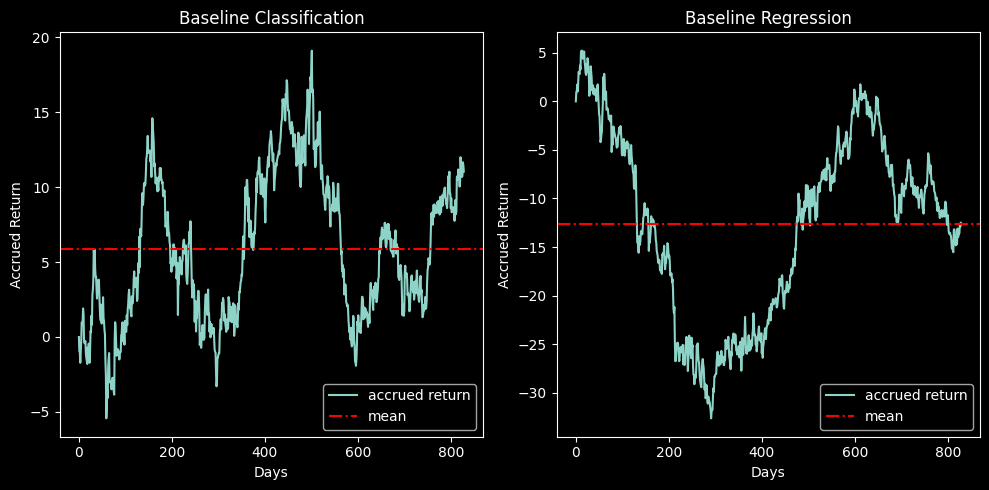

In [284]:
ret_baseline_cls = rs.simulate(test_dataset, cls_baseline)
ret_baseline_reg = rs.simulate(test_dataset, reg_baseline)

bsc_metrics = calc_metrics(ret_baseline_cls)
bsr_metrics = calc_metrics(ret_baseline_reg)

models_performance['Baseline Classification'] = bsc_metrics
models_performance['Baseline Regression'] = bsr_metrics

print('BaseLine Classification:')
print(f'\t[+] Mean:          \t{compare_numbers(bsc_metrics[1], bsr_metrics[1])}')
print(f'\t[+] Std. Deviation:\t{compare_numbers(bsc_metrics[0], bsr_metrics[0], False)}')

print('BaseLine Regression')
print(f'\t[+] Mean:          \t{compare_numbers(bsr_metrics[1], bsc_metrics[1])}')
print(f'\t[+] Std. Deviation:\t{compare_numbers(bsr_metrics[0], bsc_metrics[0], False)}')
print(80 * '=', end='\n\n')


double_plots(
    'Baseline Classification',
    ret_baseline_cls,
    'Baseline Regression',
    ret_baseline_reg,
)

## ***Random Forest Classifier***

RandomForestClassifier:
	[+] Mean:          	19.86402895054313
	[+] Std. Deviation:	21.029003251133965
RandomForestClassifier Normalized:
	[+] Mean:          	-5.762195416163728
	[+] Std. Deviation:	5.616515153191795



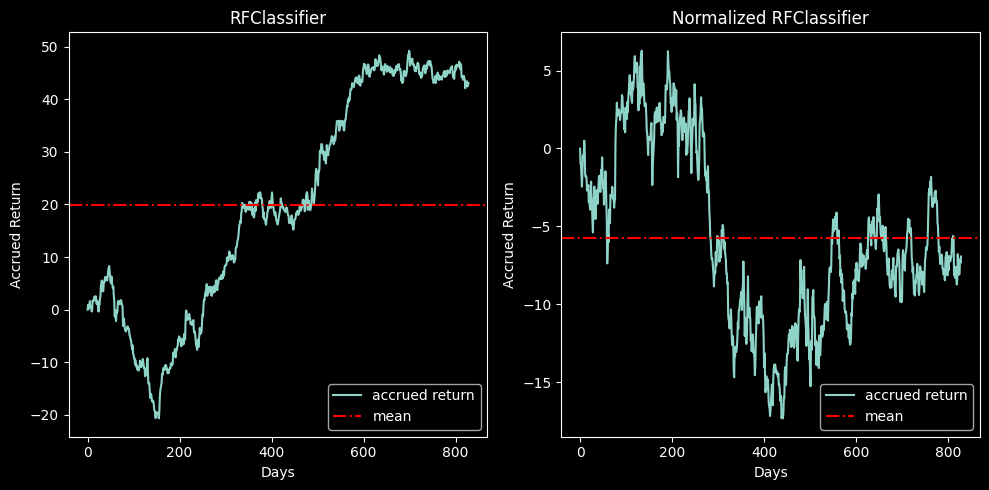

In [267]:
model_name = 'RandomForestClassifier'
ret_rfc = rs.simulate(test_dataset, guesstures[model_name])
norm_ret_rfc = rs.simulate(test_dataset, normalized_guesstures[model_name])

rfc_metrics = calc_metrics(ret_rfc)
norm_rfc_metrics = calc_metrics(norm_ret_rfc)

models_performance[f'{model_name}'] = rfc_metrics
models_performance[f'{model_name} Normalized'] = norm_rfc_metrics

print(f'{model_name}:')
print(f'\t[+] Mean:          \t{compare_numbers(rfc_metrics[1], norm_rfc_metrics[1])}')
print(f'\t[+] Std. Deviation:\t{compare_numbers(rfc_metrics[0], norm_rfc_metrics[0], False)}')

print(f'{model_name} Normalized:')
print(f'\t[+] Mean:          \t{compare_numbers(norm_rfc_metrics[1], rfc_metrics[1])}')
print(f'\t[+] Std. Deviation:\t{compare_numbers(norm_rfc_metrics[0], rfc_metrics[0], False)}')
print(80 * '=', end='\n\n')

double_plots(f'{model_name}', ret_rfc, f'{model_name} Normalized', norm_ret_rfc)

## ***MultiLayer Perceptron Classifier***

MLPClassifier:
	[+] Mean:          	5.224246079614111
	[+] Std. Deviation:	4.506117361060683
MLPClassifier Normalized:
	[+] Mean:          	14.18378769601949
	[+] Std. Deviation:	6.494587233790663



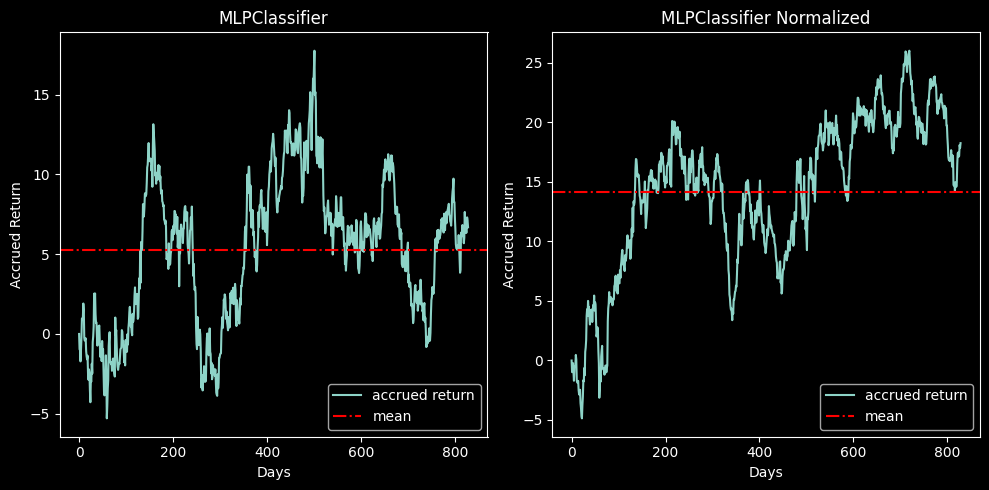

In [271]:
model_name = 'MLPClassifier'
ret_mlpc = rs.simulate(test_dataset, guesstures[model_name])
norm_ret_mlpc = rs.simulate(test_dataset, normalized_guesstures[model_name])

mlpc_metrics = calc_metrics(ret_mlpc)
norm_mlpc_metrics = calc_metrics(norm_ret_mlpc)

models_performance[f'{model_name}'] = mlpc_metrics
models_performance[f'{model_name} Normalized'] = norm_mlpc_metrics

print(f'{model_name}:')
print(f'\t[+] Mean:          \t{compare_numbers(mlpc_metrics[1], norm_mlpc_metrics[1])}')
print(f'\t[+] Std. Deviation:\t{compare_numbers(mlpc_metrics[0], norm_mlpc_metrics[0], False)}')

print(f'{model_name} Normalized:')
print(f'\t[+] Mean:          \t{compare_numbers(norm_mlpc_metrics[1], mlpc_metrics[1])}')
print(f'\t[+] Std. Deviation:\t{compare_numbers(norm_mlpc_metrics[0], mlpc_metrics[0], False)}')
print(80 * '=', end='\n\n')

double_plots(f'{model_name}', ret_mlpc, f'{model_name} Normalized', norm_ret_mlpc)

## ***Support Vector Classifier (SVC)***

SVC:
	[+] Mean:          	7.171869722557468
	[+] Std. Deviation:	8.020458310481388
SVC Normalized:
	[+] Mean:          	11.993727382388606
	[+] Std. Deviation:	8.683095023240105



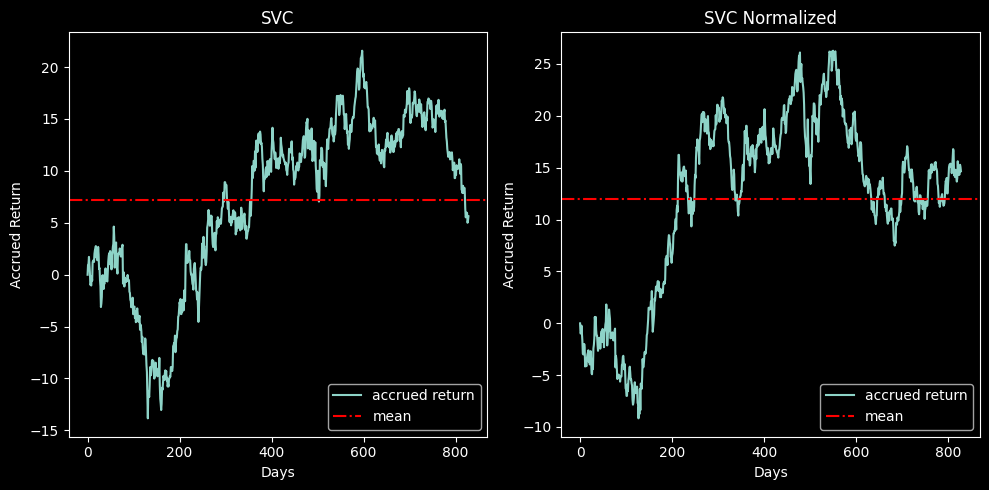

In [272]:
model_name = 'SVC'
ret_svc = rs.simulate(test_dataset, guesstures[model_name])
norm_ret_svc = rs.simulate(test_dataset, normalized_guesstures[model_name])

svc_metrics = calc_metrics(ret_svc)
norm_svc_metrics = calc_metrics(norm_ret_svc)

models_performance[f'{model_name}'] = svc_metrics
models_performance[f'{model_name} Normalized'] = norm_svc_metrics

print(f'{model_name}:')
print(f'\t[+] Mean:          \t{compare_numbers(svc_metrics[1], norm_svc_metrics[1])}')
print(f'\t[+] Std. Deviation:\t{compare_numbers(svc_metrics[0], norm_svc_metrics[0], False)}')

print(f'{model_name} Normalized:')
print(f'\t[+] Mean:          \t{compare_numbers(norm_svc_metrics[1], svc_metrics[1])}')
print(f'\t[+] Std. Deviation:\t{compare_numbers(norm_svc_metrics[0], svc_metrics[0], False)}')
print(80 * '=', end='\n\n')

double_plots(f'{model_name}', ret_svc, f'{model_name} Normalized', norm_ret_svc)

## ***K-Neighbors Classifier (KNN)***

KNeighborsClassifier:
	[+] Mean:          	-5.779034981905332
	[+] Std. Deviation:	6.366053141713448
KNeighborsClassifier Normalized:
	[+] Mean:          	15.196815440289845
	[+] Std. Deviation:	10.471438159123371



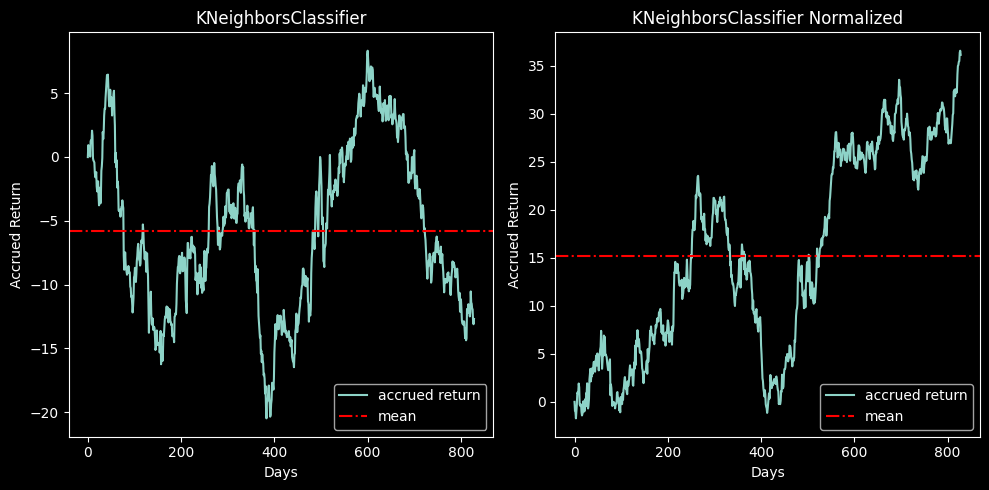

In [273]:
model_name = 'KNeighborsClassifier'
ret_knnc = rs.simulate(test_dataset, guesstures[model_name])
norm_ret_knnc = rs.simulate(test_dataset, normalized_guesstures[model_name])

knnc_metrics = calc_metrics(ret_knnc)
norm_knnc_metrics = calc_metrics(norm_ret_knnc)

models_performance[f'{model_name}'] = knnc_metrics
models_performance[f'{model_name} Normalized'] = norm_knnc_metrics

print(f'{model_name}:')
print(f'\t[+] Mean:          \t{compare_numbers(knnc_metrics[1], norm_knnc_metrics[1])}')
print(f'\t[+] Std. Deviation:\t{compare_numbers(knnc_metrics[0], norm_knnc_metrics[0], False)}')

print(f'{model_name} Normalized:')
print(f'\t[+] Mean:          \t{compare_numbers(norm_knnc_metrics[1], knnc_metrics[1])}')
print(f'\t[+] Std. Deviation:\t{compare_numbers(norm_knnc_metrics[0], knnc_metrics[0], False)}')
print(80 * '=', end='\n\n')

double_plots(f'{model_name}', ret_knnc, f'{model_name} Normalized', norm_ret_knnc)

## ***XGBoost Classifier***


XGBClassifier:
	[+] Mean:          	-3.943425814233631
	[+] Std. Deviation:	9.828953062253774
XGBClassifier Normalized:
	[+] Mean:          	2.016188178528744
	[+] Std. Deviation:	5.020727550092912



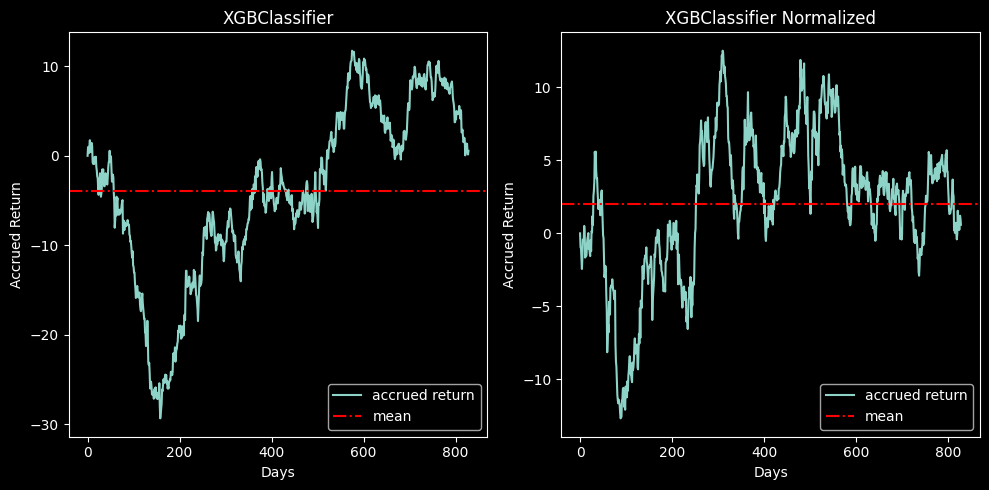

In [274]:
model_name = 'XGBClassifier'
ret_xgbc = rs.simulate(test_dataset, guesstures[model_name])
norm_ret_xgbc = rs.simulate(test_dataset, normalized_guesstures[model_name])

xgbc_metrics = calc_metrics(ret_xgbc)
norm_xgbc_metrics = calc_metrics(norm_ret_xgbc)

models_performance[f'{model_name}'] = xgbc_metrics
models_performance[f'{model_name} Normalized'] = norm_xgbc_metrics

print(f'{model_name}:')
print(f'\t[+] Mean:          \t{compare_numbers(xgbc_metrics[1], norm_xgbc_metrics[1])}')
print(f'\t[+] Std. Deviation:\t{compare_numbers(xgbc_metrics[0], norm_xgbc_metrics[0], False)}')

print(f'{model_name} Normalized:')
print(f'\t[+] Mean:          \t{compare_numbers(norm_xgbc_metrics[1], xgbc_metrics[1])}')
print(f'\t[+] Std. Deviation:\t{compare_numbers(norm_xgbc_metrics[0], xgbc_metrics[0], False)}')
print(80 * '=', end='\n\n')

double_plots(f'{model_name}', ret_xgbc, f'{model_name} Normalized', norm_ret_xgbc)

## ***Random Forest Regressor***

RandomForestRegressor:
	[+] Mean:          	-3.943425814233631
	[+] Std. Deviation:	9.828953062253774
RandomForestRegressor Normalized:
	[+] Mean:          	2.016188178528744
	[+] Std. Deviation:	5.020727550092912



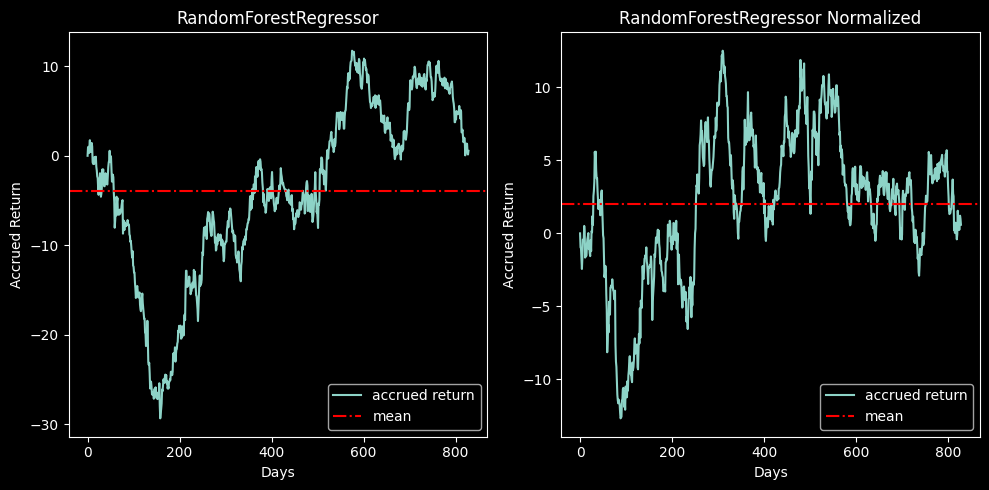

In [277]:
model_name = 'RandomForestRegressor'
ret_rfr = rs.simulate(test_dataset, guesstures[model_name])
norm_ret_rfr = rs.simulate(test_dataset, normalized_guesstures[model_name])

rfr_metrics = calc_metrics(ret_rfr)
norm_rfr_metrics = calc_metrics(norm_ret_rfr)

models_performance[f'{model_name}'] = rfr_metrics
models_performance[f'{model_name} Normalized'] = norm_rfr_metrics

print(f'{model_name}:')
print(f'\t[+] Mean:          \t{compare_numbers(rfr_metrics[1], norm_rfr_metrics[1])}')
print(f'\t[+] Std. Deviation:\t{compare_numbers(rfr_metrics[0], norm_rfr_metrics[0], False)}')

print(f'{model_name} Normalized:')
print(f'\t[+] Mean:          \t{compare_numbers(norm_rfr_metrics[1], rfr_metrics[1])}')
print(f'\t[+] Std. Deviation:\t{compare_numbers(norm_rfr_metrics[0], rfr_metrics[0], False)}')
print(80 * '=', end='\n\n')

double_plots(f'{model_name}', ret_rfr, f'{model_name} Normalized', norm_ret_rfr)

## ***MultiLayer Perceptron Regressor***

MLPRegressor:
	[+] Mean:          	-3.943425814233631
	[+] Std. Deviation:	9.828953062253774
MLPRegressor Normalized:
	[+] Mean:          	2.016188178528744
	[+] Std. Deviation:	5.020727550092912



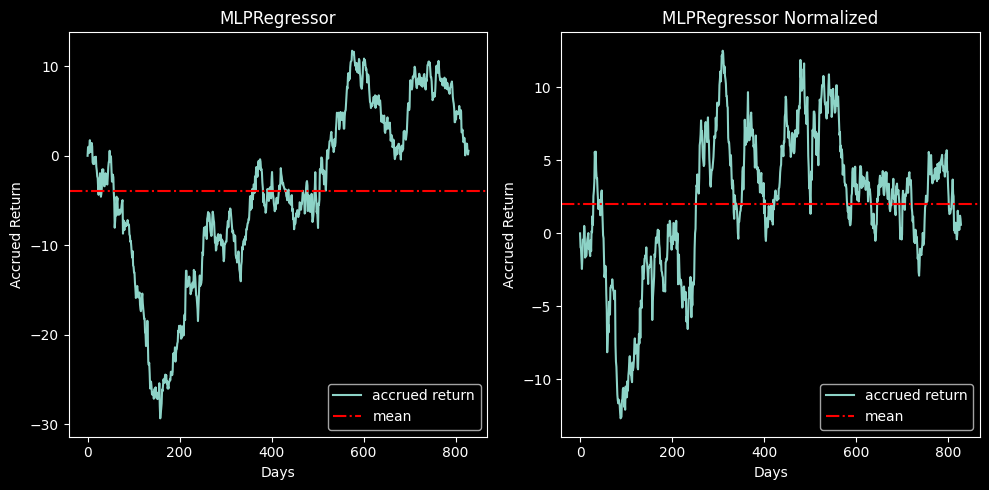

In [278]:
model_name = 'MLPRegressor'

ret_mlpr = rs.simulate(test_dataset, guesstures[model_name])
norm_ret_mlpr = rs.simulate(test_dataset, normalized_guesstures[model_name])

mlpr_metrics = calc_metrics(ret_mlpr)
norm_mlpr_metrics = calc_metrics(norm_ret_mlpr)

models_performance[f'{model_name}'] = mlpr_metrics
models_performance[f'{model_name} Normalized'] = norm_mlpr_metrics

print(f'{model_name}:')
print(f'\t[+] Mean:          \t{compare_numbers(mlpr_metrics[1], norm_mlpr_metrics[1])}')
print(f'\t[+] Std. Deviation:\t{compare_numbers(mlpr_metrics[0], norm_mlpr_metrics[0], False)}')

print(f'{model_name} Normalized:')
print(f'\t[+] Mean:          \t{compare_numbers(norm_mlpr_metrics[1], mlpr_metrics[1])}')
print(f'\t[+] Std. Deviation:\t{compare_numbers(norm_mlpr_metrics[0], mlpr_metrics[0], False)}')
print(80 * '=', end='\n\n')

double_plots(f'{model_name}', ret_mlpr, f'{model_name} Normalized', norm_ret_mlpr)

## ***Support Vector Regressor (SVR)***

SVR:
	[+] Mean:          	-3.943425814233631
	[+] Std. Deviation:	9.828953062253774
SVR Normalized:
	[+] Mean:          	2.016188178528744
	[+] Std. Deviation:	5.020727550092912



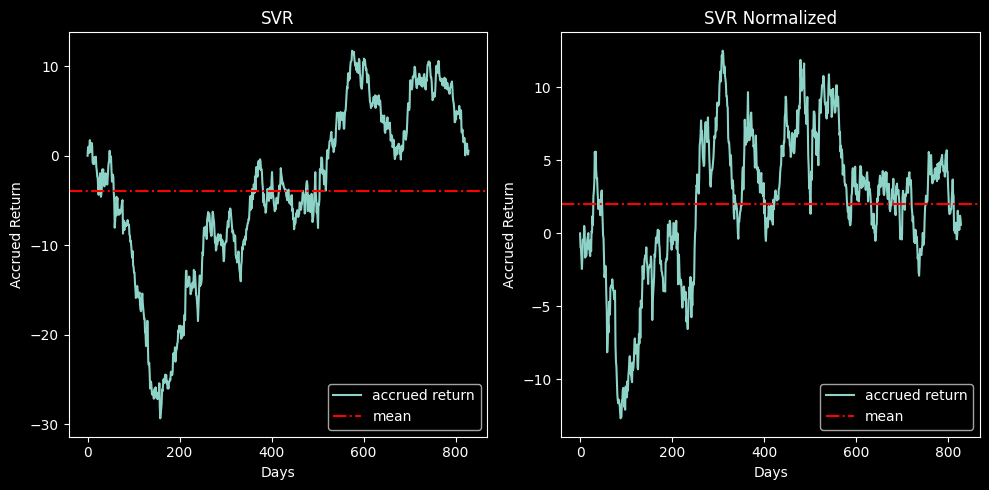

In [279]:
model_name = 'SVR'
ret_svr = rs.simulate(test_dataset, guesstures[model_name])
norm_ret_svr = rs.simulate(test_dataset, normalized_guesstures[model_name])

svr_metrics = calc_metrics(ret_svr)
norm_svr_metrics = calc_metrics(norm_ret_svr)

models_performance[f'{model_name}'] = svr_metrics
models_performance[f'{model_name} Normalized'] = norm_svr_metrics

print(f'{model_name}:')
print(f'\t[+] Mean:          \t{compare_numbers(svr_metrics[1], norm_svr_metrics[1])}')
print(f'\t[+] Std. Deviation:\t{compare_numbers(svr_metrics[0], norm_svr_metrics[0], False)}')

print(f'{model_name} Normalized:')
print(f'\t[+] Mean:          \t{compare_numbers(norm_svr_metrics[1], svr_metrics[1])}')
print(f'\t[+] Std. Deviation:\t{compare_numbers(norm_svr_metrics[0], svr_metrics[0], False)}')
print(80 * '=', end='\n\n')

double_plots(f'{model_name}', ret_svr, f'{model_name} Normalized', norm_ret_svr)

## ***K-Neighbors Regressor (KNN)***

KNeighborsRegressor:
	[+] Mean:          	-3.943425814233631
	[+] Std. Deviation:	9.828953062253774
KNeighborsRegressor Normalized:
	[+] Mean:          	2.016188178528744
	[+] Std. Deviation:	5.020727550092912



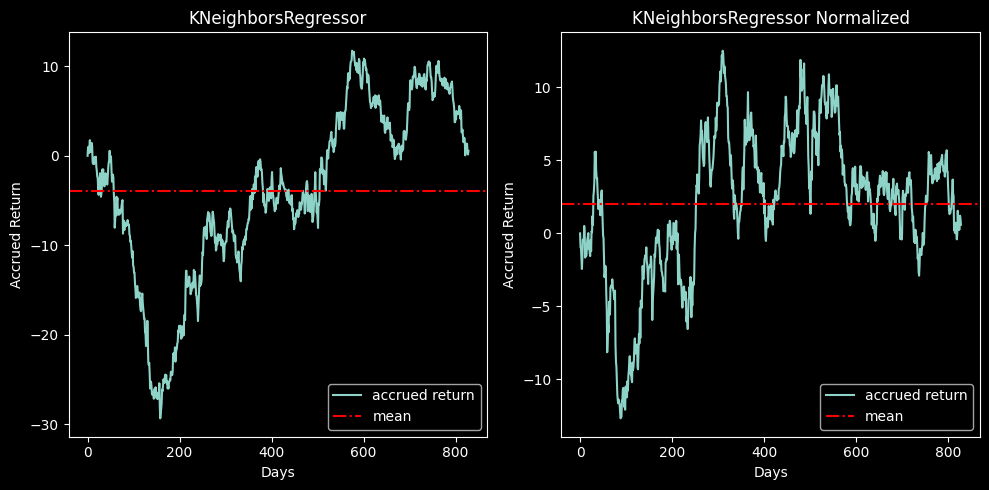

In [280]:
model_name = 'KNeighborsRegressor'
ret_knnr = rs.simulate(test_dataset, guesstures[model_name])
norm_ret_knnr = rs.simulate(test_dataset, normalized_guesstures[model_name])

knnr_metrics = calc_metrics(ret_knnr)
norm_knnr_metrics = calc_metrics(norm_ret_knnr)

models_performance[f'{model_name}'] = knnr_metrics
models_performance[f'{model_name} Normalized'] = norm_knnr_metrics

print(f'{model_name}:')
print(f'\t[+] Mean:          \t{compare_numbers(knnr_metrics[1], norm_knnr_metrics[1])}')
print(f'\t[+] Std. Deviation:\t{compare_numbers(knnr_metrics[0], norm_knnr_metrics[0], False)}')

print(f'{model_name} Normalized:')
print(f'\t[+] Mean:          \t{compare_numbers(norm_knnr_metrics[1], knnr_metrics[1])}')
print(f'\t[+] Std. Deviation:\t{compare_numbers(norm_knnr_metrics[0], knnr_metrics[0], False)}')
print(80 * '=', end='\n\n')

double_plots(f'{model_name}', ret_knnr, f'{model_name} Normalized', norm_ret_knnr)

## ***XGBoostRegressor (XGB)***

XGBRegressor:
	[+] Mean:          	-3.943425814233631
	[+] Std. Deviation:	9.828953062253774
XGBRegressor Normalized:
	[+] Mean:          	2.016188178528744
	[+] Std. Deviation:	5.020727550092912



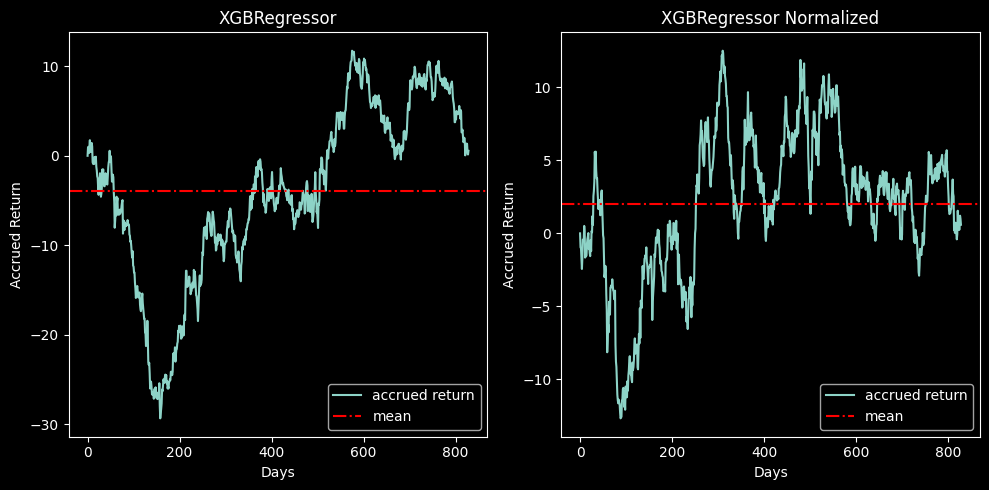

In [281]:
model_name = 'XGBRegressor'
ret_xgbr = rs.simulate(test_dataset, guesstures[model_name])
norm_ret_xgbr = rs.simulate(test_dataset, normalized_guesstures[model_name])

xgbr_metrics = calc_metrics(ret_xgbr)
norm_xgbr_metrics = calc_metrics(norm_ret_xgbr)

models_performance[f'{model_name}'] = xgbr_metrics
models_performance[f'{model_name} Normalized'] = norm_xgbr_metrics

print(f'{model_name}:')
print(f'\t[+] Mean:          \t{compare_numbers(xgbr_metrics[1], norm_xgbr_metrics[1])}')
print(f'\t[+] Std. Deviation:\t{compare_numbers(xgbr_metrics[0], norm_xgbr_metrics[0], False)}')

print(f'{model_name} Normalized:')
print(f'\t[+] Mean:          \t{compare_numbers(norm_xgbr_metrics[1], xgbr_metrics[1])}')
print(f'\t[+] Std. Deviation:\t{compare_numbers(norm_xgbr_metrics[0], xgbr_metrics[0], False)}')
print(80 * '=', end='\n\n')

double_plots(f'{model_name}', ret_xgbr, f'{model_name} Normalized', norm_ret_xgbr)

# **Visualizando o Retorno x Risco**

### Quanto **Maior** o Retorno e **Menor** o Risco, MELHOR!

RandomForestClassifier((21.029003251133965, 19.86402895054313))
RandomForestClassifier Normalized((5.616515153191795, -5.762195416163728))
MLPClassifier((4.506117361060683, 5.224246079614111))
MLPClassifier Normalized((6.494587233790663, 14.18378769601949))
SVC((8.020458310481388, 7.171869722557468))
SVC Normalized((8.683095023240105, 11.993727382388606))
KNeighborsClassifier((6.366053141713448, -5.779034981905332))
KNeighborsClassifier Normalized((10.471438159123371, 15.196815440289845))
XGBClassifier((9.828953062253774, -3.943425814233631))
XGBClassifier Normalized((5.020727550092912, 2.016188178528744))
RandomForestRegressor((9.828953062253774, -3.943425814233631))
RandomForestRegressor Normalized((5.020727550092912, 2.016188178528744))
MLPRegressor((9.828953062253774, -3.943425814233631))
MLPRegressor Normalized((5.020727550092912, 2.016188178528744))
SVR((9.828953062253774, -3.943425814233631))
SVR Normalized((5.020727550092912, 2.016188178528744))
KNeighborsRegressor((9.828953062

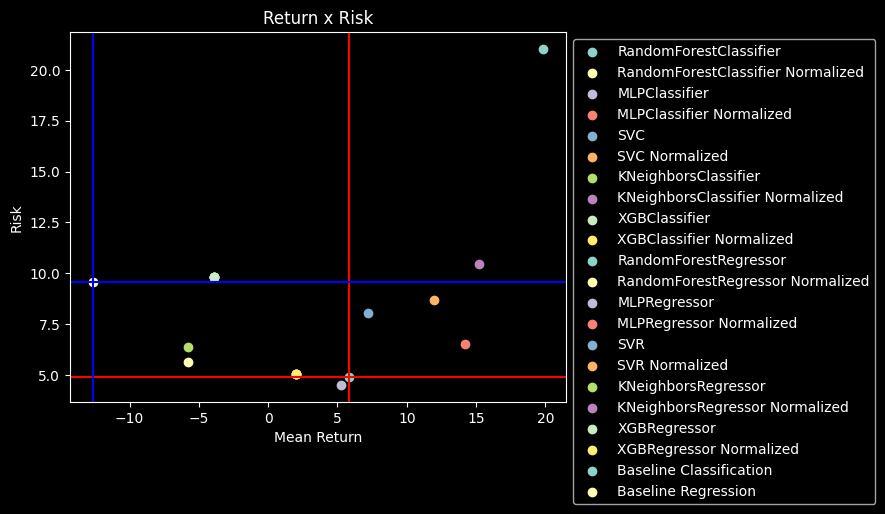

In [300]:
for model_name, model_metrics in models_performance.items():
  print(f'\033[1;97m{model_name}\033[0m({model_metrics})')
  a, b = model_metrics
  plt.scatter(b, a, label=model_name)

# Use Baseline as reference
plt.axhline(y=models_performance['Baseline Classification'][0], color='r', linestyle='-')
plt.axvline(x=models_performance['Baseline Classification'][1], color='r', linestyle='-')

plt.axhline(y=models_performance['Baseline Regression'][0], color='b', linestyle='-')
plt.axvline(x=models_performance['Baseline Regression'][1], color='b', linestyle='-')

plt.xlabel('Mean Return')
plt.ylabel('Risk')
plt.title('Return x Risk')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()